# _Python for Scientific Data Analysis_


#  Bayesian Inference and Markov Chain Monte Carlo methods

MCMC stands for "Markov-Chain Monte Carlo" and you see it _everywhere_ in (astro)physics and adjacent fields now.   This section of the course builds towards using MCMC methods to model complex data. 

But before we dive into running MCMC -- our goal later -- we need to understand what it is we are actually doing.  That means first talking about Bayesian inference/statistics and introducing the Monte Carlo method more generally as well as parameter posterior distributions (Section 1).  After we do that, only then do we launch into the Markov Chain Monte Carlo method (Section 2).

## Section 1: An Introduction To Bayesian Inference and Monte Carlo Methods

**caveats**

(caveat: a lot of this is indebted to Daniel Foreman-Mackey and Imad Pasha.  Please browse their work on https://dfm.io/ and https://prappleizer.github.io/.  I also borrowed a bit of text from Charles Greyer (U. Minnesota) )

(caveat #2: your instructor has a heavy frequentist bias by training but likes (MC)MC largely for its parameter space exploration and clear visualization of correlations between parameters in leading, widely-used code.  Some of the presentation may reflect this "upbringing".)

### Packages Used in This Notebook

The "machinery" of doing Monte Carlo methods will be handled by NumPy calls; most visualization by Matplotlib.   
We also want to plot modeling outputs.  Monte Carlo codes give us posterior distributions which then allows us to plot not just these distributions but correlations in the posterior distributions between different parameters in our model.   The widely-used package for this is the logically-named ``corner`` package.  Note that making the output from simple Monte Carlo code "work" with ``corner`` takes a few extra steps but hopefully this is clear.  

We will eventually be using the ``emcee`` package for doing MCMC, a Python implementation of the affine-invariant ensemble sampler for Markov chain Monte Carlo (MCMC) (Goodman and Weare 2010).   It makes up the engine of many MCMC codes used today (e.g. the dynamical code ``orvara``).   

You can install ``emcee`` and ``corner`` from pip or from conda:

E.g.
```
pip install corner
pip install emcee
```

We will then import these packages along with our standard import calls for doing numerical Python and displaying data:

In [82]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import corner
import emcee

### Background: Frequentist vs. Bayesian Inference

 Now, we have covered model fitting before in our SciPy section, where we talked about different optimization algorithms, statistics, and goodness-of-fit.   In many of the optimization algorithms, we had to give the algorithm an initial guess.  We then define formal confidence intervals based on the goodness-of-fit of a model(s) to data.  

But ultimately, we had always been approaching model fitting, uncertainties, etc. from a _frequentist_ approach.   Here, frequentists use concepts like p-values and confidence intervals to assess evidence against a null hypothesis.   This contrasts with the _Bayesian_ approach we will adopt here.   

Put simply, we are interested in the probability of different model parameters and the two approaches -- frequentist and Bayesian -- have different views on what "probabilty" means.  To a frequentist, a "probability" is equivalent to (as the name implies) a "frequency" of events occurring.    E.g. a bona fide single 5-$\sigma$ positive detection in a single given experiment will instead be noise $\sim$3$\times$10$^{-7}$ of the time.  For a Bayesian, probability means "certainty", i.e. the strength of a belief.  (A sketch of) [t]he idea originates from Thomas Bayes (and a few others), a Presbyterian minister, philosopher, and statistician who died before seeing his eponymous idea published.   

_Key Differences_

* You do not actually assign a probability to the hypothesis you are testing but in a Bayesian approach you do.
  
* Aside from initial "guesses" for parameters for the purpose of model fitting, the frequentist is agnostic about the what the answer _should_ be.   However, a Bayesian considers our _expected_ results given prior evidence.
  
   This may seem like a bit circular logic and not very "objective" (shouldn't we avoid prejudging what nature tells you?).  But it does agree more with how we actually evaluate evidence in practice and the idea that once the data are revealed, then it should result in a shift of our ideas about what the "right" models are.  

   Thus, in Bayesian statistics we impose a _**prior**_ probability distribution for a certain set of models being correct.   These priors encode information we as modelers think we already know about the system we are modeling.   For example, if we are doing an MCMC modeling a planet orbiting a star detected with radial-velocity or astrometry, we might set priors on the mass (can't be more massive than the star; more likely to have a lower Msin(i), etc.) and orbit (unlikely to be $>$ 1000 au and more likely to be at a small separation if we can detect with RV, etc.).   This probability is then updated as a _posterior_ probability after the data are evaluated.

### How Bayesian Inference Works
So how do we ascribe this "certainty" in Bayesian statistics?  We consider a model where data $x$ are generated from a probability distribution depending on parameter $\theta$.  Our _prior_ knowledge about the parameter $\theta$ is expressed as p($\theta$).   We then observe the data and determine "how probable are the observed data given is this parameter $\theta$"?   This is written as $Pr(x|\theta)$.  Finally, we ask "how probable is it to observe these particular data themselves?" ($p(x)$) 

The "certainty" we have of the parameter given the data is then:


$$p(\theta|x) = \frac{p(x|\theta)p(\theta)}{p(x)}$$

Or more crudely ...

$$p(model|data) = \frac{p(data|model)p(model)}{p(data)}$$

Or more crudely + roughly ...

$$p(model|data) \propto p(data|model)p(model)$$

The language describing each of these terms is usually cast in terms of a _**prior**_, a _**likelihood**_, and a _**posterior**_ :

-   $p(\theta)$: our **prior** belief about the parameters
-   $p(x \mid \theta)$: the **likelihood**, telling us
    how probable the data are for different parameter values
-   $p(\theta \mid x)$: the **posterior**, our updated
    belief after plugging in the data

In other words, the end goal of Bayesian inference is to **describe the posterior distribution**.
This distribution contains everything we want: e.g. it can show the mean value of the posterior, some confidence interval in a parameter, the covariance between ranges of different parameters, etc.

You might then think "okay, we can't we just fit a model with SciPy and be done with it? This sounds like a Rube-Goldberg machine approach to science."   But even in seemingly simple cases -- as we shall see -- this is not quite correct.  And for most research grade applications (e.g. things that were not solved long before modern computers) the posterior is usually too complicated to compute analytically.  In fact, in many cases it is way way too complicated (as we shall see below).

### The Monte Carlo Method

A "Monte Carlo" simulation is a name for a simulation of probability distributions and calculating probabilities and expectations by averaging over the simulations. At the time the term was invented, the casino at Monte Carlo (in Monaco) was the most famous in the world (Vegas casinos had yet to really take off).  Gambling has something to do with probability (which is news to some people who gamble): hence the name.   You can think of the Monte Carlo method at its core as "[t]hrow darts randomly at the entire board, then give different weights to throws based on how close they land to the bullseye".  

But it's more than that: a "Monte Carlo" simulation is more useful than just a roll of the (parameter space) dice.  Any integral or sum that cannot be done analytically, either by hand or by a computer algebra system can be put in the form of the expectation of some random variable with respect to some probability distribution. So a Monte Carlo method is a general method of sampling -- e.g. doing integrals or sums -- over complex parameter spaces.

Monte Carlo methods use **random sampling** to approximate quantities that are difficult to compute directly. The basic idea:

1.  Draw many random samples from a known distribution.
2.  Use those samples to approximate integrals, expectations, or
    uncertainties.

Plain Monte Carlo works well when we can directly sample from the
distribution of interest.

### _Parameter Estimation with Monte Carlo Methods_

For models with low dimensionality (e.g. 1--5 free parameters) and relatively simple posteriors, a plain Monte Carlo simulation works fine.  

The key things to define for a Monte Carlo method are: 

- **$N_{sample}$** - the number of samples for your MC simulation.

- A **model function** usually by a $\theta$ vector that contains a set of parameters.  For example, a simple model that the RV-amplitude induced on a star as a function of time due to an orbiting planet is based on the stellar mass $M_{\rm star}$, $Msin(i)$, and $n$ different orbital parameters ($O$) such as the eccentricity, semimajor axis, periastron passage, etc: 
 \begin{equation}\theta = \begin{pmatrix} M_{star} \\ Msin(i) \\ O_{0...n-1} \end{pmatrix} \end{equation}

The model prediction given vector $\theta$ is then $f(\theta)$ [note: this example is probably too complex to actually do right with plain Monte Carlo without a lot of shortcuts but you get the point ...].

- A **prior probability distribution** on the model parameters.  For a plain Monte Carlo simulation, the prior is going to be uniform over your parameter space of interest.   I.e. the _prior_ is a binary "yes/no" indicator.   E.g. if you have two parameters you are trying to fit -- $j$ and $k$ -- and you have minimimum and maximum values to explore for these parameters (e.g. $k_{min}$ and $k_{max}$), then code setting up your prior should look something like this:

```
  #N_samples different uniform random draws between j_min and j_max
  j_samples = np.random.uniform(j_min, j_max, N_samples)
  #ditto for k
  k_samples = np.random.uniform(k_min, k_max, N_samples)  
```


  
- A **likelihood function** of that model being correct ($\mathcal{L}(\theta|x)$).   The mathematical form of this function will depend entirely by your data-generating process (the physical/statistical model of how your observations arise). You choose the likelihood based on what distribution actually describes your data.  E.g. for a normal/Gaussian likelihood this form will be:

$$\mathcal{L}(\theta|x)= \prod_{i = 1}^{n}  p(x_{i}|\theta) = \prod_{i = 1}^{n}(\frac{1}{{2\pi\sigma_i^{2}}})^{1/2}e^{-0.5(x_{i}-f_{i}(\theta))^{2}/\sigma_i^{2})}$$

I.e. you have a normal/gaussian probability density distribution for each measurement $i$ and the likelihood function just multiples all these together.  Note that $\mathcal{L}(\theta|x)$ and $p(x_{i}|\theta)$ mean slightly different things.  The former is "the likelihood of $\theta$ given $x$" and the latter is "the probability of $x$ given $\theta$". 

The above expression then reduces to ...  


$$\mathcal{L}(\theta|x)= \prod_{i = 1}^{n}  p(x_{i}|\theta) = \prod_{i = 1}^{n}[(\frac{1}{{2\pi\sigma_i^{2}}})^{1/2}]e^{-0.5(\sum_{i = 1}^{n}(x_{i}-f_{i}(\theta))^{2})/\sigma_i^{2})}$$.



The standard way to express the likelihood function is the ``log-likelihood`` since it avoids numerical problems from multiplying together small probabilities and separations constant terms from data dependent terms.   It also makes clearer that each observation is weighted by 1/$\sigma_{i}^{2}$:

$$ln\mathcal{L}(\theta|x) = -\frac{n}{2}ln(2\pi) -\sum_{i = 1}^{n}ln(\sigma_{i})  -\frac{1}{2}\sum_{i = 1}^{n} \frac{(x_{i}-f_{i}(\theta))^{2}}{\sigma_i^{2}}$$

or alternatively ...

$$ln\mathcal{L}(\theta|x) = -\frac{1}{2} \sum_{i = 1}^{n}[ln(2\pi\sigma_{i}^{2})  + \frac{(x_{i}-f_{i}(\theta))^{2}}{\sigma_i^{2}}]$$

(if you're thinking that this form looks a lot like the $\chi^{2}$ statistic -- e.g. log-likelihood $\sim$ -0.5$\times$$\chi^{2}$... you're right!).

**One more thing**, the notation looks confusing at first glance.  I.e. aren't we trying to calculate the "probability of the data, given the model" but the equation seems to say "likelihood of model given the data"?  That seems inconsistent right?  No. (and honestly this confused me for a long time too).  

That is because "probability density function of the data, given the model" has the same numerical value as the "likelihood of model given the data" (caveat: though note that these are conceptually different statements:  $p(x|\theta)$ is a probability density over x given $\theta$, while $\mathcal{L}(\theta|x)$ is a measure of support for $\theta$ (not a probability over $\theta$).  So we can also write this as ...

 $$ln{p}(x|\theta) = -\frac{1}{2} \sum_{i = 1}^{n}[ln(2\pi\sigma_{i}^{2})  + \frac{(x_{i}-f_{i}(\theta))^{2}}{\sigma_i^{2}}]$$


As we mentioned in the SciPy section, there are different distributions of data than a normal/Gaussian distribution, and these different distributions result in different likelihood functions: e.g. for a Poisson distribution (for discrete counts) we instead get $\mathcal{L}(\theta|x) = \prod_{i = 1}^{n} (\lambda^{i} e^{-\lambda_{i}})/x_{i}! $, etc.   But the predominant application we will face (where the data is a continuous distribution and normally distributed), the normal/Gaussian distribution formalation of the likelihood function is what we want.

_**Putting it all together**_

We define $N_{sample}$ Monte Carlo samples and define a uniform range in parameters of our models in between some limits (i.e. our prior). Over a loop of $N_{sample}$ samples, for a given iteration $a$ we then randomly draw some combination of parameters $\theta_{a}$.  We compute the log-likelihood of the model given the data for this combination of parameters.   

Finally, we compute the likelihood-weighted values (``loglike``) for different parameter combinations in our model.  We define weights by converting the log-likelihood back to a likelihood (``likelihood = np.exp(loglike - np.max(loglike))``).  

You then multiple each instance of the parameter space explored by its likelihood. and compute the posterior distribution of each parameter by taking the percentile weighted by the likelihood (e.g. ``np.nanpercentile(parameter,50,weights=likelihood)``.
  




### _A Very Simple (and Contrived) Example: Fitting A Line to Data_ 

Let's start with a simple and highly contrived situation -- fitting a line to data -- which illustrates how the Monte Carlo method works.  We will then later use this same simple example for a _Markov Chain_ Monte Carlo simulation.

As is clear from the previous section, we are going to need functions 1) that generate models with a specific set of parameters $\theta$, 2) some parameter initialization that will give a uniform prior probability distribution for each parameter $\theta$ over some limits, and 3) that compute a likelihood function describing the agreement.   

As our test, we're going to consider a linear model where the quoted
uncertainties are underestimated by a constant fractional amount.
You can generate a synthetic dataset from this model:

EXAMPLE 1: Fitting a Line to Data with Monte Carlo


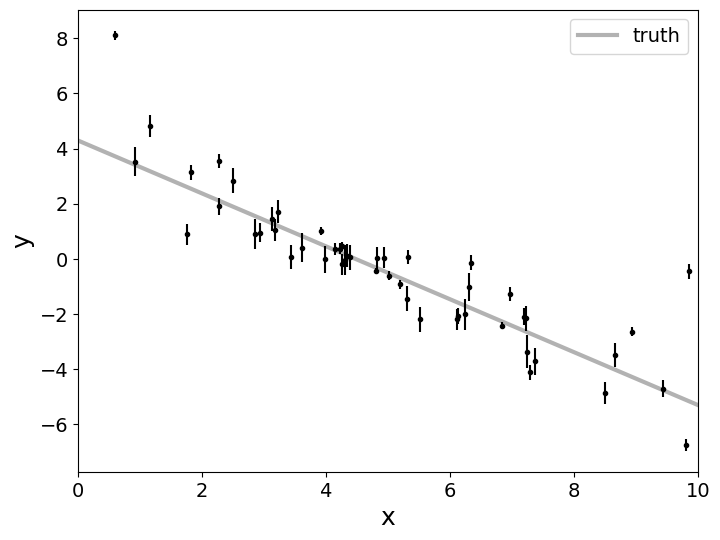

In [83]:
print("="*70)
print("EXAMPLE 1: Fitting a Line to Data with Monte Carlo")
print("="*70)

#plt.figure(figsize=(8,6))
np.random.seed(123)

# Choose the "true" parameters.
m_true = -0.9594
b_true = 4.294
f_true = 0.534

# Generate some synthetic data from the model.
N = 50
x = np.sort(10 * np.random.rand(N))
yerr = 0.1 + 0.5 * np.random.rand(N)
y = m_true * x + b_true
y += np.abs(f_true * y) * np.random.randn(N)
y += yerr * np.random.randn(N)

fig,ax=plt.subplots(figsize=(8,6))

ax.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)
x0 = np.linspace(0, 10, 500)
ax.plot(x0, m_true * x0 + b_true, "k", alpha=0.3, lw=3,label="truth")
ax.set_xlim(0, 10)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.tick_params(axis='both', which='minor', labelsize=10)
ax.set_xlabel("x",fontsize=18)
ax.set_ylabel("y",fontsize=18)
ax.legend(loc='best',fontsize=14);

The true model is shown as the thick grey line and the effect of the
underestimated uncertainties is obvious when you look at this figure.
The standard way to fit a line to these data (assuming independent Gaussian
error bars) is linear least squares.
Linear least squares is appealing because solving for the parameters—and
their associated uncertainties—is simply a linear algebraic operation.
Following the notation in [Hogg, Bovy & Lang (2010)](https://arxiv.org/abs/1008.4686), the linear least squares solution to these
data is

Least-squares estimates:
m = -1.104 ± 0.016
b = 5.441 ± 0.091


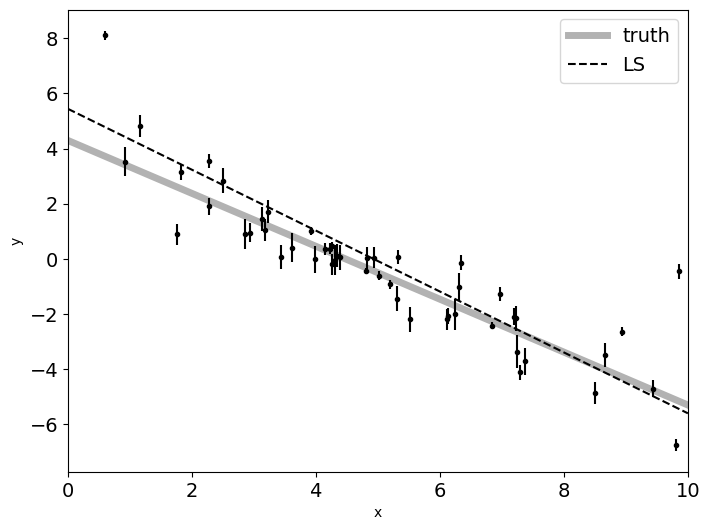

In [84]:
A = np.vander(x, 2) 
#note: this is a Vandermonde matrix: prints out x as the first column and "1" as each entry in the second.
# Think of it as "what a least-squares minimization with errors does "under the hood"
# see the notes from Hogg et al. (2010)

#print(x)
#print(A)

C = np.diag(yerr * yerr) 
#assuming that the data point measurements are independent; 
#otherwise the off-diagonal terms would be non-zero

ATA = np.dot(A.T, A / (yerr**2)[:, None])
cov = np.linalg.inv(ATA)
w = np.linalg.solve(ATA, np.dot(A.T, y / yerr**2))
print("Least-squares estimates:")
print("m = {0:.3f} ± {1:.3f}".format(w[0], np.sqrt(cov[0, 0])))
print("b = {0:.3f} ± {1:.3f}".format(w[1], np.sqrt(cov[1, 1])))

fig,ax=plt.subplots(figsize=(8,6))
ax.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)
ax.plot(x0, m_true * x0 + b_true, "k", alpha=0.3, lw=5, label="truth")
ax.plot(x0, np.dot(np.vander(x0, 2), w), "--k", label="LS")
ax.legend(fontsize=14)
ax.set_xlim(0, 10)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.tick_params(axis='both', which='minor', labelsize=10)
ax.set_xlabel("x")
ax.set_ylabel("y");

(Note: this analytical solution may seem to come out of nowhere but see Equations 2--6 in Hogg et al. 2010).

This figure shows the least-squares estimate of the line parameters as a dashed line.
This isn't an unreasonable result but the uncertainties on the slope and
intercept seem a bit little small (because of the small error bars on most of the
data points) and probably underestimated.

## Setting up the Monte Carlo simulation


As mentioned above, to do a MC simulation you need several key ingredients besides setting the number of samples :

* A number of samples
* A **model function**
* A **prior probability distribution** on the model parameters, and 
* A **likelihood function** of that model being correct

Let's go through these in detail ...

First, we just choose the number of samples we want for the Monte Carlo simulation.  Let's set it to something big like 500,000.
```
n_samples=500000
```

#### _Model Function_

In this particular case, the nominal model function is very simple: 

``y = mx+b``, 

where we have measurment errors of $\sigma$.  However, it is clear in the example that our nominal error bars are underestimated.  So we model their underestimation as a constant parameter ``f``.

#### _Likelihood Function_
We now need a function to describe the likelihood of a particular model.   This function takes as an argument theta as well as the $x$, $y$, and $y_{err}$ of your actual theta. It's job is to return a number corresponding to how good a fit your model is to your data for a given set of parameters, weighted by the error in your data points. Assuming the errors are correct, the log-likelihood formulation is the same as above:

$$ln\mathcal{L}(\theta|x) = ln{p}(x|\theta) = -\frac{1}{2} \sum_{i = 1}^{n}[ln(2\pi\sigma_{i}^{2})  + \frac{(x_{i}-f_{i}(\theta))^{2}}{\sigma_i^{2}}]$$

Now, the least squares solution found in the previous section is the maximum
likelihood result for a model where the error bars are assumed correct,
Gaussian and independent. From just looking at the fit, we can probably guess that the error bars have been slightly underestimated. So we are going to model that by inflating the model errors by a constant $f$ value.

Therefore, $\sigma$ in the above equation is modified from the original  ... 
$$
    \sigma_i^2 = \sigma_{i,o}^2+f^2\,(m\,x_n+b)^2 \quad ,
$$

Where $\sigma_{i,o}$ are our original errors and $\sigma_n$ are the inflated errors (inflated by some constant factor of the data value).

#### _Priors_

For priors we just have to think carefully about what is reasonable for the data.  For this simple case, we can just eyeball it to identify "reasonable" answers.  E.g. the line is obviously going down so the slope should be weighted towards values that are less than zero.  We set the considered range for the slope, intercept and log of the inflating factor to be ...

```
# Define priors (uniform distributions)
m_min, m_max = -2.0, 0.5
b_min, b_max = 0.0, 10.0
f_min,f_max=-10,-1 #this is actually log(f)
```

Then we initilize the arrays as ...
```
# Sample from priors
m_samples = np.random.uniform(m_min, m_max, n_samples)
b_samples = np.random.uniform(b_min, b_max, n_samples)
f_samples = np.random.uniform(f_min, f_max, n_samples)
```

### _Running the Monte Carlo Simulation_

Putting it all together, our code looks a bit like this ...

In [85]:
# Monte Carlo sampling
#n_samples = 50000
n_samples = 200000

# Define priors (uniform distributions)
m_min, m_max = -2.0, 0.5
b_min, b_max = 0.0, 10.0
#f_min, f_max = 0.0, 1.0
f_min,f_max=-10, 1 #this is actually log(f)

# Sample from priors
m_samples = np.random.uniform(m_min, m_max, n_samples)
b_samples = np.random.uniform(b_min, b_max, n_samples)
f_samples = np.random.uniform(f_min, f_max, n_samples)
log_f=f_samples.copy() #just clarifying these are log-f values

In [86]:
# Calculate likelihood for each sample
log_likelihoods = np.zeros(n_samples)

for i in range(n_samples):
    y_model = m_samples[i] * x + b_samples[i]
    # Total uncertainty includes intrinsic scatter and measurement error
    #sigma_total = np.sqrt(yerr**2 + (f_samples[i] * y_model)**2)
    sigma_total = np.sqrt(yerr**2 + y_model**2*np.exp(2*log_f[i]) ) 
    residuals = y - y_model
    #log_likelihoods[i] = -0.5 * np.sum((residuals / sigma_total)**2 + np.log(2 * np.pi * sigma_total**2))
    log_likelihoods[i] = -0.5 * np.sum((residuals / sigma_total)**2 + np.log(2 * np.pi *sigma_total**2))

# Convert to probabilities (unnormalized)
likelihoods = np.exp(log_likelihoods - np.max(log_likelihoods))

Finally, we calcuate weighted statistics as follows ... 

In [87]:
# Calculate weighted statistics
m_mean = np.average(m_samples, weights=likelihoods)
b_mean = np.average(b_samples, weights=likelihoods)
f_mean = np.average(f_samples, weights=likelihoods)

m_mean2=np.mean(np.repeat(m_samples,np.round(likelihoods).astype(int)))
b_mean2=np.mean(np.repeat(b_samples,np.round(likelihoods).astype(int)))
f_mean2=np.mean(np.repeat(f_samples,np.round(likelihoods).astype(int)))

m_std = np.sqrt(np.average((m_samples - m_mean)**2, weights=likelihoods))
b_std = np.sqrt(np.average((b_samples - b_mean)**2, weights=likelihoods))
f_std = np.sqrt(np.average((f_samples - f_mean)**2, weights=likelihoods))

print("\nMonte Carlo estimates:")
print(r"Slope (m): {0:.4f} +/- {1:.4f}".format(m_mean,m_std))
print(r"Intercept (b): {0:.4f} +/- {1:.4f}".format(b_mean, b_std))
print(r"Fractional scatter (log-f): {0:.4f} +/- {1:.4f}".format(f_mean, f_std))

print(m_mean2,b_mean2,f_mean2)


Monte Carlo estimates:
Slope (m): -1.0112 +/- 0.0885
Intercept (b): 4.5656 +/- 0.3996
Fractional scatter (log-f): -0.7777 +/- 0.1466
-0.9930528323505147 4.484672482557125 -0.7812131781058523


/var/folders/jd/2nq0dfy94lsddczv0kg2y33h0000gn/T/ipykernel_63619/4221079334.py:31: RuntimeWarning: divide by zero encountered in divide
  counts = (likelihoods / likelihoods.min())
/var/folders/jd/2nq0dfy94lsddczv0kg2y33h0000gn/T/ipykernel_63619/4221079334.py:31: RuntimeWarning: invalid value encountered in divide
  counts = (likelihoods / likelihoods.min())


the max 1.0


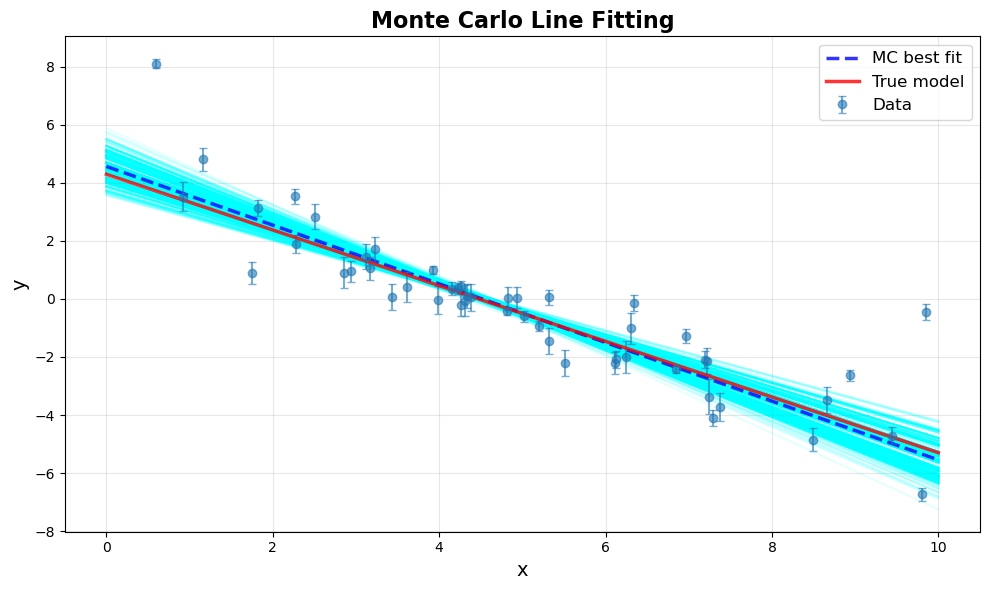

In [88]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

x_plot = np.linspace(0, 10, 1000)

#
inds = np.random.choice(n_samples, size=1000, 
                          p=likelihoods/np.sum(likelihoods))

for ind in inds:
    #plt.plot(x_plot, m_samples2[ind]*x_plot+b_samples2[ind], color='cyan', alpha=0.1)
    plt.plot(x_plot, m_samples[ind]*x_plot+b_samples[ind], color='cyan', alpha=0.1)

# Plot MC best fit
y_mc_line = m_mean * x_plot + b_mean
ax.plot(x_plot, y_mc_line, 'b--', linewidth=2.5, label='MC best fit', alpha=0.8)

# Plot data
ax.errorbar(x, y, yerr=yerr, fmt='o', alpha=0.6, label='Data', 
            markersize=6, capsize=3)

# Plot true line

y_true_line = m_true * x_plot + b_true
ax.plot(x_plot, y_true_line, 'r-', linewidth=2.5, label='True model', alpha=0.8)

#explicitly multiply by likelihood
m_samples2=np.repeat(m_samples,(likelihoods).astype(int))
b_samples2=np.repeat(b_samples,(likelihoods).astype(int))
f_samples2=np.repeat(f_samples,(likelihoods).astype(int))

counts = (likelihoods / likelihoods.min())
print('the max',np.max(likelihoods))


    
#y_mc_line_tot=m_samples[ind]*x_plot+b_samples[ind]
#ax.plot(x_plot,y_mc_line_tot,color='cyan', alpha=0.1)

ax.set_xlabel('x', fontsize=14)
ax.set_ylabel('y', fontsize=14)
ax.set_title('Monte Carlo Line Fitting', fontsize=16, fontweight='bold')
ax.legend(fontsize=12, loc='best')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### Visualizing Posterior Distributions with Corner Plots

The plot above shows that there is obviously some range in values for the slope and intercept posterior distributions.   But showing a histogram distribution of each of these parameters communicates more information than just quoting the mean, median, or 68% confidence interval.

Additionally, you might want to understand how the parameters are _correlated_.  Are there particular combinations of parameters that are unlikely?   Are there some degenerate solutions?   Is the posterior symmetric? Is it single-peaked or bimodal?   Just showing a 1D histogram doesn't answer these questions.

A _corner plot_ visualizes the full structure of the full posterior distribution cleanly, showing distributions for individual parameters and covariance between the parameters.  The layout of a corner plot forms a triangle (i.e. "a corner").    A corner plot clearly reveals that we are determining a **joint** posterior for different parameters.

We create a corner plot with ``corner.py``

In [89]:
# =============================================================================
# Create Corner Plot
# =============================================================================
print("\n" + "-"*70)
print("Creating corner plot of posterior distributions...")
print("-"*70)

# Resample according to posterior weights to create samples distributed 
# according to the posterior (like MCMC would naturally produce)
#n_corner_samples = 500000
n_corner_samples = 5000000

#a random sample is generated from n_samples
#If an ndarray, a random sample is generated from its elements. If an int -- which it is in this case --
#the random sample is generated as if it were np.arange(a)

#so you do 5000 random draws from the parent sample, p=likelihoods/np.sum(likelihoods) sets the relative likelihood of a particular draw

indices = np.random.choice(n_samples, size=n_corner_samples, 
                          p=likelihoods/np.sum(likelihoods), replace=True)

# Create array of posterior samples
samples_posterior = np.column_stack([m_samples[indices], 
                                     b_samples[indices], 
                                     f_samples[indices]])


----------------------------------------------------------------------
Creating corner plot of posterior distributions...
----------------------------------------------------------------------


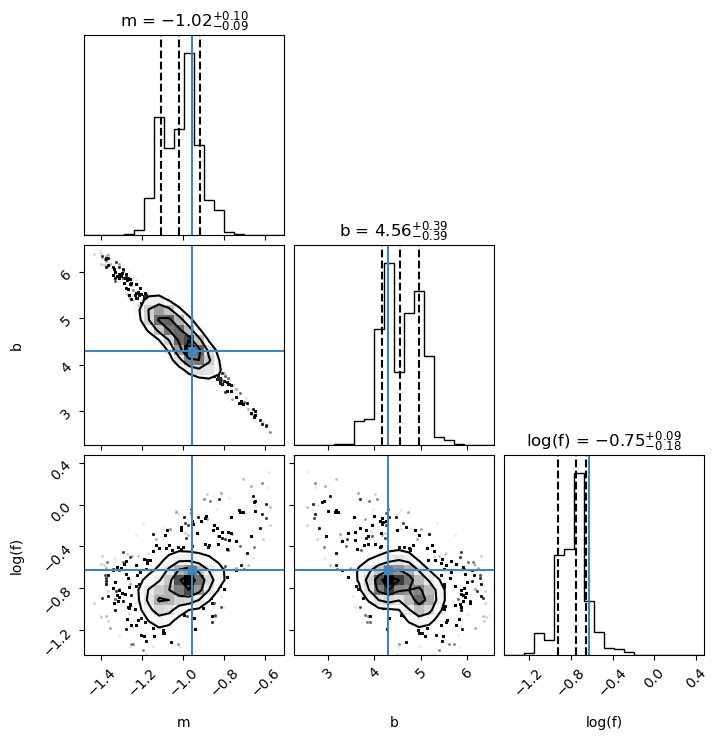

In [90]:
# =============================================================================
# The Corner Plot
# =============================================================================
labels = ["m", "b", "log(f)"]

#fig_corner = corner.corner(
#    samples_posterior, 
#    labels=['Slope $m$', 'Intercept $b$', '$f$'],
#    quantiles=[0.16, 0.5, 0.84],
#    show_titles=True,
#    title_kwargs={"fontsize": 12},
#    title_fmt='.4f',
#    smooth=1.0,
#    truth_color='red',
#    plot_datapoints=True,
#    fill_contours=False,
#    levels=[0.68, 0.95],  # 1-sigma and 2-sigma contours
#)


fig = corner.corner(samples_posterior,show_titles=True,truths=[m_true, b_true, np.log(f_true)],smooth=1.0,
                     labels=labels,plot_datapoints=True,quantiles=[0.16, 0.5, 0.84])

### _A Slightly More Scientifically Interesting Example_

Here, we will create mock radial-velocity data for a planet and estimate parameters using a simple Monte Carlo simulation.

In [91]:
# Generate synthetic RV data for a planet
def rv_model(t, K, P, e, omega, t0):
    """Radial velocity model for a planet"""
    # Mean anomaly
    M = 2 * np.pi * (t - t0) / P
    
    # Solve Kepler's equation iteratively for eccentric anomaly E
    E = M.copy()
    for _ in range(10):
        E = M + e * np.sin(E)
    
    # True anomaly
    nu = 2 * np.arctan2(np.sqrt(1 + e) * np.sin(E/2), 
                         np.sqrt(1 - e) * np.cos(E/2))
    
    # RV
    rv = K * (np.cos(nu + omega) + e * np.cos(omega))
    return rv

# True planet parameters
true_K = 50.0  # RV semi-amplitude (m/s)
true_P = 100.0  # Period (days)
true_e = 0.2  # Eccentricity
true_omega = np.pi/4  # Argument of periastron
true_t0 = 20.0  # Time of periastron
true_rv_sigma = 10.0  # RV uncertainty


# Generate observations
t_obs = np.sort(np.random.uniform(0, 300, 40)) #create 40 random observations between 0 and 300 days
rv_true = rv_model(t_obs, true_K, true_P, true_e, true_omega, true_t0)
rv_obs = rv_true + np.random.normal(0, true_rv_sigma, len(t_obs))
rv_err = np.full_like(rv_obs, true_rv_sigma)

In [98]:
# Monte Carlo sampling (simplified: fix period, fit other parameters)
n_samples_rv = 100000

#"priors" are defined by ranges in parameters
K_samples = np.random.uniform(20, 80, n_samples_rv)
e_samples = np.random.uniform(0, 0.5, n_samples_rv)
omega_samples = np.random.uniform(0, 2*np.pi, n_samples_rv)
t0_samples = np.random.uniform(0, true_P, n_samples_rv)


# Calculate likelihoods
log_likes_rv = np.zeros(n_samples_rv)

for i in range(n_samples_rv):
    rv_model_i = rv_model(t_obs, K_samples[i], true_P, e_samples[i], 
                          omega_samples[i], t0_samples[i])
    log_likes_rv[i]= -0.5*(np.sum(((rv_obs - rv_model_i) / rv_err)**2 + np.log(2*np.pi*rv_err**2)))
    #log_likes_rv[i]= -0.5*(np.sum(((rv_obs - rv_model_i) / rv_err)**2 ))
    #chi2 = np.sum(((rv_obs - rv_model_i) / rv_err)**2) #simplified
    #log_likes_rv[i] = -0.5 * chi2

In [99]:
likes_rv = np.exp(log_likes_rv - np.max(log_likes_rv))

# Best-fit parameters
K_best = np.average(K_samples, weights=likes_rv)
e_best = np.average(e_samples, weights=likes_rv)
omega_best = np.average(omega_samples, weights=likes_rv)
t0_best = np.average(t0_samples, weights=likes_rv)

print(f"\nTrue parameters:")
print('K = {0:.2f} m/s, e = {1:.3f}, ω = {2:.3f} rad, t0 = {3:.2f} days'.format(true_K,true_e,true_omega,true_t0))
#print(f"  K = {true_K:.2f} m/s, e = {true_e:.3f}, ω = {true_omega:.3f} rad, t0 = {true_t0:.2f} days")
print(f"\nMonte Carlo estimates:")
print(f"  K = {K_best:.2f} +/- {np.sqrt(np.average((K_samples-K_best)**2, weights=likes_rv)):.2f} m/s")
print(f"  e = {e_best:.3f} +/- {np.sqrt(np.average((e_samples-e_best)**2, weights=likes_rv)):.3f}")
print(f"  omega = {omega_best:.3f} +/- {np.sqrt(np.average((omega_samples-omega_best)**2, weights=likes_rv)):.3f} rad")
print(f"  t0 = {t0_best:.2f} +/- {np.sqrt(np.average((t0_samples-t0_best)**2, weights=likes_rv)):.3f} days")

# Calculate planet minimum mass
#assume one solar mass
M_star = 1.0  # Solar masses
m_planet_sin_i = (K_best) * np.sqrt(1 - e_best**2) * \
                 (M_star * 1.989e30)**(2/3) * \
                 (true_P * 86400 / (2*np.pi*(6.6743e-11)))**(1/3)  
m_planet_sin_i_mjup = m_planet_sin_i / 1.89813e27

msini_jup_pos= (K_samples) * np.sqrt(1 - e_samples**2) * \
                 (M_star * 1.989e30)**(2/3) * \
                 (true_P * 86400 / (2*np.pi*(6.6743e-11)))**(1/3) 

print(f"\nDerived minimum mass: {m_planet_sin_i_mjup:.5f} M_Jup")


True parameters:
K = 50.00 m/s, e = 0.200, ω = 0.785 rad, t0 = 20.00 days

Monte Carlo estimates:
  K = 51.79 +/- 2.52 m/s
  e = 0.266 +/- 0.046
  omega = 0.579 +/- 0.184 rad
  t0 = 17.12 +/- 2.303 days

Derived minimum mass: 1.14037 M_Jup


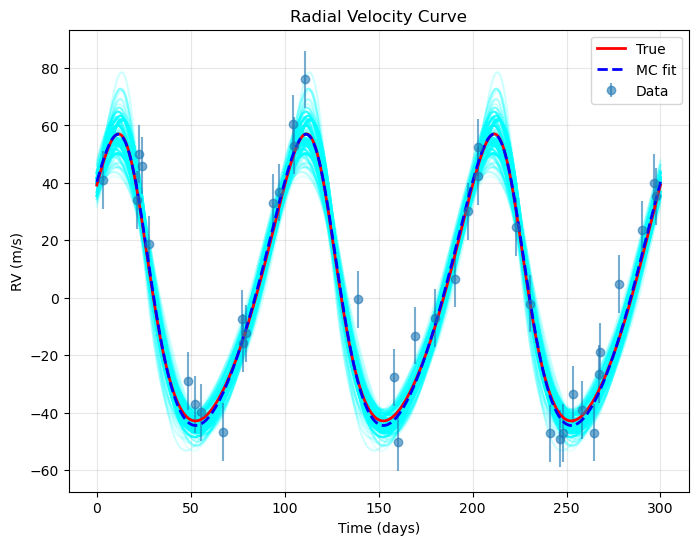

In [72]:
# Plotting
fig, axes = plt.subplots(figsize=(8,6))

# RV curve
t_model = np.linspace(0, 300, 500)
inds = np.random.choice(n_samples_rv, size=500, 
                          p=likes_rv/np.sum(likes_rv),replace=True)


rv_true_curve = rv_model(t_model, true_K, true_P, true_e, true_omega, true_t0)
rv_best_curve = rv_model(t_model, K_best, true_P, e_best, omega_best, t0_best)


for ind in inds:
    #plt.plot(x_plot, m_samples2[ind]*x_plot+b_samples2[ind], color='cyan', alpha=0.1)
    plt.plot(t_model, rv_model(t_model, K_samples[ind], true_P, 
                               e_samples[ind], omega_samples[ind], t0_samples[ind]), color='cyan', alpha=0.1)

axes.errorbar(t_obs, rv_obs, yerr=rv_err, fmt='o', alpha=0.6, label='Data')
axes.plot(t_model, rv_true_curve, 'r-', linewidth=2, label='True')
axes.plot(t_model, rv_best_curve, 'b--', linewidth=2, label='MC fit')
axes.set_xlabel('Time (days)')
axes.set_ylabel('RV (m/s)')
axes.legend()
axes.set_title('Radial Velocity Curve')
axes.grid(True, alpha=0.3)
plt.show()

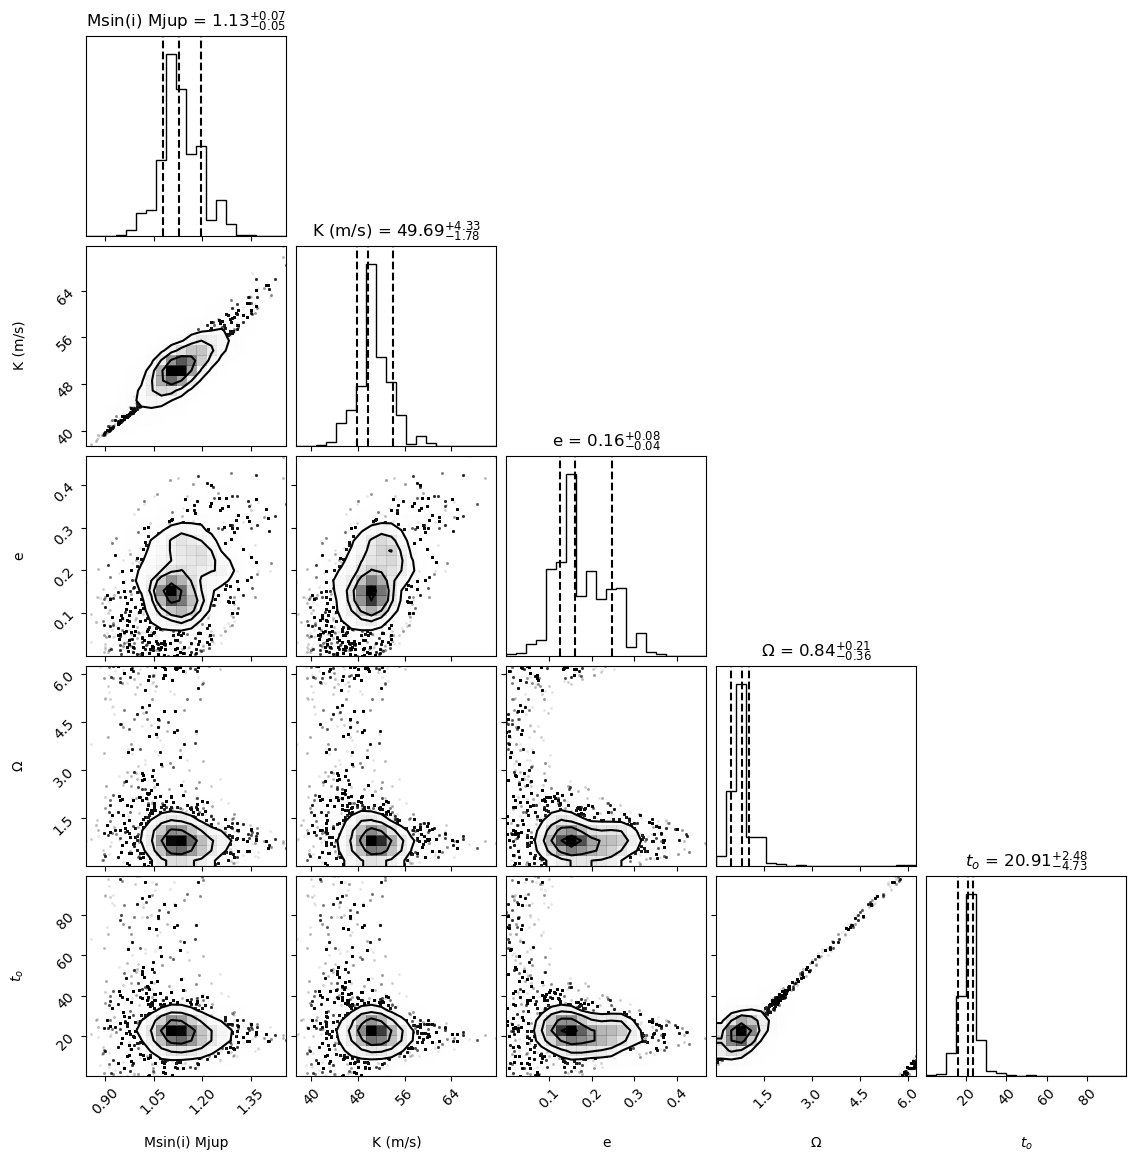

In [78]:
#Corner plot!

# =============================================================================
# The Corner Plot
# =============================================================================

n_corner_samples = 5000000
indices = np.random.choice(n_samples_rv, size=n_corner_samples, 
                          p=likes_rv/np.sum(likes_rv),replace=True)

# Create array of posterior samples
samples_posterior = np.column_stack([msini_jup_pos[indices]/1.898e27, 
                                     K_samples[indices],
                                     e_samples[indices], 
                                     omega_samples[indices],
                                     t0_samples[indices]])


labels = ["Msin(i) Mjup", "K (m/s)", "e",r'$\Omega$',r'$t_{o}$']


fig = corner.corner(samples_posterior,show_titles=True,smooth=1.0,
                     labels=labels,plot_datapoints=True,quantiles=[0.16, 0.5, 0.84])